### Section Notes

In this section, we will be tuning Random Forest Model

### Setting up

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import optuna
import sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Helper method
# You may consider changeing the colour scheme in practice

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Loading Data

We will not do the train-test split again and again

#### Loading Data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/ST4248 Project/dataset/train_normalised.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ST4248 Project/dataset/test_normalised.csv')

# Guan Yee directory
#df_train = pd.read_csv('/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Project/dataset/train_normalised_new.csv')
#df_test = pd.read_csv('/content/drive/MyDrive/NUS/2022 2023 Sem 2/ST4248 Project/dataset/test_normalised_new.csv')

In [ ]:
df_train.head()

,hotel,lead_time,arrival_date_month,arrival_date_week_number,adults,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,num.guests,stays,is_company_paid,get_reserved,is_canceled
0,0,-0.236864,10,41,0.288481,5,3,0,-0.102601,-0.086744,...,2.691958,3,0.695531,-0.254599,-0.721368,0.041345,-0.577205,0,0,0
1,1,0.492576,5,28,0.288481,3,1,0,2.250536,-0.086744,...,-0.132459,3,-0.082042,-0.254599,0.542329,0.041345,0.609178,0,1,1
2,0,2.802471,1,34,0.288481,4,3,0,-0.102601,-0.086744,...,-0.132459,2,-0.889604,-0.254599,-0.721368,0.041345,-0.577205,0,1,1
3,0,-0.704454,11,38,0.288481,6,3,0,-0.102601,-0.086744,...,-0.132459,2,0.462045,-0.254599,1.806026,0.041345,-0.972666,0,1,0
4,0,-0.180753,4,4,0.288481,4,3,0,1.073967,-0.086744,...,1.844633,2,-0.396927,-0.254599,-0.721368,0.041345,-0.972666,0,1,1


In [ ]:
X_train = df_train.drop("is_canceled", axis = 1)
y_train = df_train["is_canceled"]

X_test = df_test.drop("is_canceled", axis = 1)
y_test = df_test["is_canceled"]

### Bayesian Tuner

**没事别乱跑，一跑一小时**

In [ ]:
def objective(trial):
  params_grid = {
      "n_estimators" : trial.suggest_int("n_estimators", 50, 200),
      "max_depth" : trial.suggest_int("max_depth", 25, 100),
      "min_samples_split": trial.suggest_int("min_sample_split", 2, 10),
      "min_samples_leaf": trial.suggest_int("min_sample_leaf", 1, 20),
      "max_features": trial.suggest_int("max_features", 1, 23)
  }
  model = RandomForestClassifier(random_state = 42, **params_grid)
  score = cross_val_score(model, X_train, y_train, cv = 5).mean()
  return score

params_grid edited based on DT. reduce range.

in the following: value edited accordingly.

In [ ]:
study = optuna.create_study(direction = "maximize")

#Add the default as baseline
study.enqueue_trial(
    {"n_estimators": 100,
    "max_depth": 25,
    "min_samples_split": 2,
    "min_samples_leaf": 5,
     "max_features": 5}
)

study.optimize(objective, n_trials = 20)

trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}= {}, ".format(key, value))

[I 2023-04-07 12:40:47,585] A new study created in memory with name: no-name-593a0278-309c-40b7-bcdc-3e413d72d43a
[I 2023-04-07 12:41:30,029] Trial 0 finished with value: 0.8565589089514211 and parameters: {'n_estimators': 100, 'max_depth': 25, 'min_sample_split': 6, 'min_sample_leaf': 1, 'max_features': 5}. Best is trial 0 with value: 0.8565589089514211.
[I 2023-04-07 12:45:33,435] Trial 1 finished with value: 0.8528374318549453 and parameters: {'n_estimators': 181, 'max_depth': 26, 'min_sample_split': 6, 'min_sample_leaf': 6, 'max_features': 22}. Best is trial 0 with value: 0.8565589089514211.
[I 2023-04-07 12:46:38,830] Trial 2 finished with value: 0.851361029733401 and parameters: {'n_estimators': 98, 'max_depth': 49, 'min_sample_split': 2, 'min_sample_leaf': 7, 'max_features': 10}. Best is trial 0 with value: 0.8565589089514211.
[I 2023-04-07 12:46:51,841] Trial 3 finished with value: 0.8120232927883414 and parameters: {'n_estimators': 95, 'max_depth': 27, 'min_sample_split': 10, 

### Testing Tuned Random Forest

Please add the best candidate in this section.

--------RF--------
Correctly classified instances: 30345
Accuracy Score is 0.86391
Recall Score is 0.9193
Precision Score is 0.8695
F1 Score is 0.89371
       0      1
0  10250   3016
1   1764  20095
[[10250  3016]
 [ 1764 20095]]


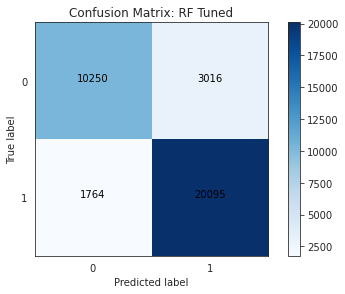

In [ ]:
print("--------RF--------")
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42,
                               n_estimators= 100, 
                               max_depth= 100, 
                               min_samples_split= 2, 
                               max_features = 5,
                               min_samples_leaf= 1)
model.fit(X_train, y_train)


y_predict = model.predict(X_test)

y_predict_fixed = np.logical_not(y_predict)
y_test_fixed = np.logical_not(y_test)

y_predict_fixed = y_predict_fixed.astype(int)
y_test_fixed = y_test_fixed.astype(int)

print(f'Correctly classified instances: {sum(y_predict_fixed == y_test_fixed)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test_fixed, y_predict_fixed)))
print('Recall Score is {:.5}'.format(recall_score(y_test_fixed, y_predict_fixed)))
print('Precision Score is {:.5}'.format(precision_score(y_test_fixed, y_predict_fixed)))
print('F1 Score is {:.5}'.format(f1_score(y_test_fixed, y_predict_fixed)))
print(pd.DataFrame(confusion_matrix(y_test_fixed,y_predict_fixed)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test_fixed,y_predict_fixed),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: RF Tuned')

### Tuning Analysis

#### Analysis on Hypermeter Importance

In [ ]:
optuna.visualization.plot_param_importances(study)

#### Analysis on a single feature

In the R package, the only parameter we tune is the mtry, the equivalence of sklearn's 'max_features' parameter. It would be interesting to see how different max_features would affect the CV error.

Kindly note that this plot cannot be used to choose our max_features parameter, as we have other factors to further augment our RF model.

In [ ]:
max_features_range = range(1, 23, 2)

In [ ]:
list(max_features_range)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

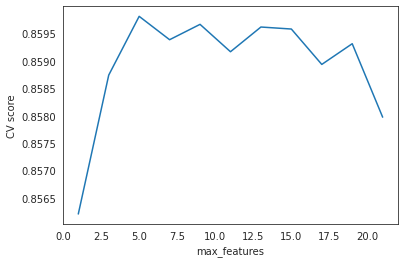

In [ ]:
# Compute CV scores for each max_depth value
cv_scores = []
for max_features in max_features_range:
    model_DT = RandomForestClassifier(max_features=max_features, random_state = 42)
    scores = cross_val_score(model_DT, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

# Plot the CV scores against max_depth
plt.plot(max_features_range, cv_scores)
plt.xlabel('max_features')
plt.ylabel('CV score')
plt.show()

In [ ]:
cv_scores

[0.8562050644155056,
 0.8587429889791499,
 0.8598167147280737,
 0.8593896637499915,
 0.8596702787680714,
 0.8591700124153053,
 0.8596214826614338,
 0.8595848630640696,
 0.8589381815938403,
 0.8593164431646729,
 0.8579742744406837]

### Analysis of num trees

In [ ]:
n_tree_range = range(50, 500, 10)

In [ ]:
list(n_tree_range)

[50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490]

In [ ]:
# Compute CV scores for each max_depth value
cv_scores = []
for n_trees in n_tree_range:
    model_RF = RandomForestClassifier(n_estimators=n_trees, random_state = 42)
    scores = cross_val_score(model_RF, X_train, y_train, cv=3, scoring='accuracy')
    cv_scores.append(np.mean(scores))

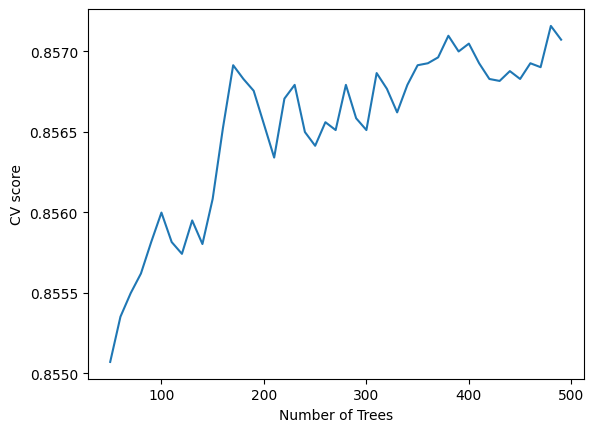

In [ ]:
# Plot the CV scores against max_depth
plt.plot(n_tree_range, cv_scores)
plt.xlabel('Number of Trees')
plt.ylabel('CV score')
plt.show()

In [ ]:
cv_scores

[0.8550703417645839,
 0.8553509767317008,
 0.8554973949754139,
 0.8556194101785083,
 0.8558146345034592,
 0.8559976573081006,
 0.8558146345034591,
 0.8557414253816026,
 0.8559488512268628,
 0.8558024329831496,
 0.8560830679502667,
 0.856522322681406,
 0.8569127713313079,
 0.856827360689142,
 0.8567541515672853,
 0.856546725722025,
 0.8563392998767646,
 0.8567053454860476,
 0.8567907561282135,
 0.8564979196407873,
 0.8564125089986212,
 0.8565589272423343,
 0.8565101211610967,
 0.8567907561282135,
 0.8565833302829532,
 0.8565101211610967,
 0.8568639652500701,
 0.8567663530875947,
 0.8566199348438815,
 0.8567907561282135,
 0.8569127713313079,
 0.8569249728516173,
 0.8569615774125455,
 0.8570957941359493,
 0.8569981819734739,
 0.8570469880547117,
 0.8569249728516173,
 0.856827360689142,
 0.8568151591688324,
 0.8568761667703796,
 0.856827360689142,
 0.8569249728516173,
 0.8569005698109985,
 0.8571568017374965,
 0.8570713910953304]